In [47]:
import pandas as pd
import os
import git
import numpy as np
import seaborn as sns
import matplotlib as plt
import time

def get_git_root(path):

        git_repo = git.Repo(path, search_parent_directories=True)
        #git_root = git_repo.git.rev_parse("--show-toplevel")
        
        return git_repo.working_dir

In [2]:
top_level_git_dir = get_git_root(os.getcwd())
raw_data_dir = os.path.join(top_level_git_dir, "data", "raw")

train_csv_path = os.path.join(raw_data_dir, "train_values.csv")
test_csv_path = os.path.join(raw_data_dir, "test_values.csv")
train_labels_csv_path = os.path.join(raw_data_dir, "train_labels.csv")
submission_format_csv_path = os.path.join(raw_data_dir, "submission_format.csv")

train_df = pd.read_csv(train_csv_path, index_col = "row_id")
train_labels_df = pd.read_csv(train_labels_csv_path, index_col = "process_id")
test_df = pd.read_csv(test_csv_path, index_col = "row_id")
submission_format_csv_path = pd.read_csv(submission_format_csv_path, index_col = "process_id")


/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
response_dict = {}
for proc_id in train_df.process_id.unique():
    final_phase_for_proc = train_df[(train_df.process_id == proc_id) & (train_df.target_time_period == True)]
    final_phase_for_proc = final_phase_for_proc.assign(final_phase_turbidity = \
        np.maximum(0, final_phase_for_proc.return_flow) * final_phase_for_proc.return_turbidity)
    proc_id_response = final_phase_for_proc["final_phase_turbidity"].sum()
    
    response_dict[proc_id] = proc_id_response

In [4]:
response_dict

{20001: 4318275.12554818,
 20002: 437528.57109794125,
 20003: 427197.73393308267,
 20004: 719783.0261053684,
 20005: 413310.6503749337,
 20008: 4100847.0864118547,
 20011: 3058669.195203994,
 20014: 2706871.4373974237,
 20016: 521755.33349069883,
 20017: 103724.28729467509,
 20018: 1366681.8465563094,
 20019: 53408.509967789665,
 20023: 1875568.3397814478,
 20025: 327966.6135227812,
 20030: 508890.15811140987,
 20033: 668203.1933072086,
 20035: 433945.2282390981,
 20037: 314885.3107635207,
 20039: 1763055.4335154223,
 20042: 689355.9961675403,
 20043: 1585300.1251132558,
 20044: 349528.2890806126,
 20045: 983082.6895779017,
 20046: 1079254.346558409,
 20047: 326358.14896491176,
 20049: 660466.9393707704,
 20050: 553740.272660489,
 20051: 59006.66805360914,
 20053: 1707946.5172790927,
 20057: 758868.590742599,
 20058: 58417.41697918879,
 20062: 589065.7840487394,
 20065: 692860.5903703257,
 20066: 557125.276612133,
 20067: 10079370.048694504,
 20070: 454609.2506713714,
 20071: 25770.556

In [5]:
def prep_full_df(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    df = df.assign(turbidity_in_liters = \
        np.maximum(0, df.return_flow) * df.return_turbidity)

    df['process_phase'] = df.process_id.astype(str) + "_" + df.phase.astype(str)
    df = df[df.phase != "final_rinse"]
    
    return df

In [6]:
def prep_metadata(df):
    meta_df = df[["process_id", "pipeline"]].drop_duplicates().set_index("process_id")
    meta_df = pd.get_dummies(meta_df)
    
    if 'L12' not in meta_df.columns:
        meta_df['pipeline_L12'] = False
    
    for col in meta_df.columns:
        if "pipeline" in col:
            meta_df[col] = meta_df[col].astype(bool)
    meta_df["num_phases"] = df.groupby("process_id")["phase"].apply(lambda x: x.nunique())
    return meta_df


In [7]:
ts_cols = [
    'process_id',
    'timestamp',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    "turbidity_in_liters"
]

def prep_time_series_features(df, columns = None):
    
    if columns is None:
        columns = df.columns
    
    df = df.sort_values(by=["process_id", "timestamp"], ascending=True)
    process_duration = df.groupby('process_id')["timestamp"].max() - df.groupby('process_id')["timestamp"].min() 
    process_duration = process_duration.rename('process_duration')
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # define fxn before calling in .agg to make col name more descriptive (in place of <lambda>)
    def last_five_mean(x):
        return x.tail(5).mean()
    
    ts_features_agg_df = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', last_five_mean])
    
    ts_features_df = pd.concat([process_duration, ts_features_agg_df], axis = 1)
    return ts_features_df

In [8]:
def clean_feature_df(df):
    
    new_col_names = []
    for col in df.columns.ravel():
        if isinstance(col, str):
            new_col_names.append(col)
        elif isinstance(col, tuple):
            col_name = "{}_{}".format(col[0], col[1])
            new_col_names.append(col_name)
    df.columns = new_col_names
    
    return df

In [9]:
def create_feature_matrix(df):
    
    prepped_df = prep_full_df(df)
    metadata_df = prep_metadata(prepped_df)
    time_series_df = prep_time_series_features(prepped_df)
    
    dfs_to_concat = [metadata_df, time_series_df]
    
    feature_df = pd.concat(dfs_to_concat, axis=1)
    
    df_to_return = clean_feature_df(feature_df)

    
    return df_to_return

In [10]:
train_features_df = create_feature_matrix(train_df)

In [11]:
indices_to_keep = list(set(train_features_df.index).intersection(set(train_labels_df.index)))

# figure out why 16 indices dropped out of train_features_df
train_labels_df = train_labels_df[train_labels_df.index.isin(indices_to_keep)]

In [12]:
train_features_w_response = train_features_df.join(train_labels_df)
train_features_w_response.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,tank_concentration_acid_max,tank_concentration_acid_mean,tank_concentration_acid_std,tank_concentration_acid_last_five_mean,turbidity_in_liters_min,turbidity_in_liters_max,turbidity_in_liters_mean,turbidity_in_liters_std,turbidity_in_liters_last_five_mean,final_rinse_total_turbidity_liter
process_id,,,,,,,,,,,,,,,,,,,,,
20001,False,False,False,False,False,False,True,False,False,False,...,52.411568,44.711593,0.648487,44.653038,818.406942,1.579919e+06,105488.460366,174650.861160,30300.051942,4.318275e+06
20002,False,False,False,False,False,True,False,False,False,False,...,44.708210,44.332388,0.079575,44.229616,499.442792,2.976941e+06,854203.372900,563689.439444,949644.159635,4.375286e+05
20003,False,False,False,False,False,True,False,False,False,False,...,46.888943,44.548272,0.319453,44.716846,152.522484,1.431140e+06,44218.000816,127420.220308,5287.641592,4.271977e+05
20004,False,False,False,False,False,False,False,False,True,False,...,45.862520,44.604458,0.390013,45.226021,0.000000,3.162818e+06,212923.854423,387856.686586,22306.533910,7.197830e+05
20005,False,False,False,False,False,False,False,False,True,False,...,44.412254,43.921479,0.249111,43.952939,0.000000,2.066256e+05,23587.698324,26813.228206,45723.010454,4.133107e+05


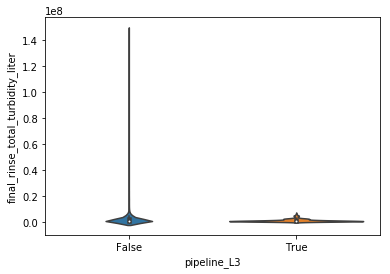

In [13]:
plt = sns.violinplot(x = 'pipeline_L3', y = 'final_rinse_total_turbidity_liter', data = train_features_w_response).get_figure()
plt.savefig("output.png")


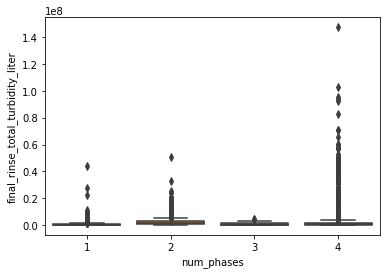

In [14]:
ax = sns.boxplot(x="num_phases", y="final_rinse_total_turbidity_liter", data=train_features_w_response)

In [15]:
a = pd.crosstab(index=train_features_w_response["num_phases"], columns="count")
#a.loc[True]["count"]
a

col_0,count
num_phases,
1,240
2,1017
3,22
4,3726


[Text(0, 0.5, 'final_rinse_total_turbidity_liter'),
 Text(0.5, 0, 'supply_pressure_max'),
 Text(0.5, 1.0, 'Title')]

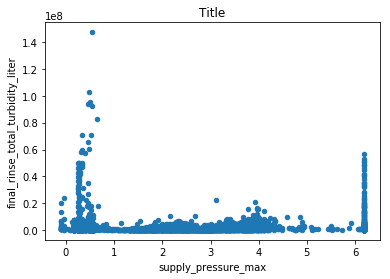

In [16]:
(train_features_w_response
 .plot
 .scatter(x='supply_pressure_max', y='final_rinse_total_turbidity_liter')
 .set(title='Title',
      xlabel='supply_pressure_max',
      ylabel='final_rinse_total_turbidity_liter'))

/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


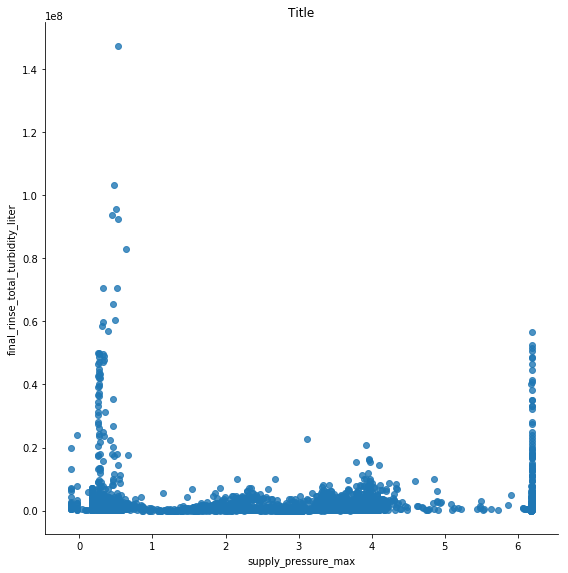

In [17]:
plt = sns.lmplot("supply_pressure_max", "final_rinse_total_turbidity_liter", fit_reg = False, size=8, data=train_features_w_response)
ax = plt.axes.flatten()
title = ax[0].set_title("Title")


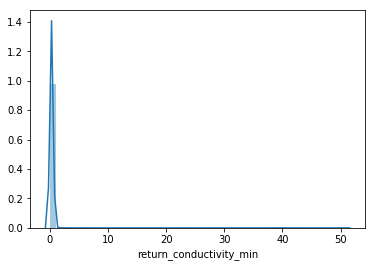

In [18]:
sns_plot = sns.distplot(train_features_w_response["return_conductivity_min"]).get_figure()


In [19]:
#train_features_w_response.columns
for col in train_features_w_response.columns:
    print(col, train_features_w_response[col].dtype)

pipeline_L1 bool
pipeline_L10 bool
pipeline_L11 bool
pipeline_L12 bool
pipeline_L2 bool
pipeline_L3 bool
pipeline_L4 bool
pipeline_L6 bool
pipeline_L7 bool
pipeline_L8 bool
pipeline_L9 bool
num_phases int64
process_duration timedelta64[ns]
supply_flow_min float64
supply_flow_max float64
supply_flow_mean float64
supply_flow_std float64
supply_flow_last_five_mean float64
supply_pressure_min float64
supply_pressure_max float64
supply_pressure_mean float64
supply_pressure_std float64
supply_pressure_last_five_mean float64
return_temperature_min float64
return_temperature_max float64
return_temperature_mean float64
return_temperature_std float64
return_temperature_last_five_mean float64
return_conductivity_min float64
return_conductivity_max float64
return_conductivity_mean float64
return_conductivity_std float64
return_conductivity_last_five_mean float64
return_turbidity_min float64
return_turbidity_max float64
return_turbidity_mean float64
return_turbidity_std float64
return_turbidity_las

In [20]:
for col in train_features_w_response.columns:
    if "pipeline" in col:
        train_features_w_response[col] = train_features_w_response[col].astype(bool)

In [96]:
def get_categorical_plot(df, col_name, col_type, response_var):
    
    plot_output_folder = os.path.join(top_level_git_dir, "src", "visualizations")
    col_plot_output_folder = os.path.join(plot_output_folder, col_name)
    
    if not os.path.exists(col_plot_output_folder):
        os.makedirs(col_plot_output_folder)
        
    xtab = pd.crosstab(index=df[col_name], columns="count")
    if col_type == "bool":
        true_ct = xtab.loc[True]["count"] if True in list(xtab.index.values) else None
        false_ct = xtab.loc[False]["count"]
        plot_title = "False: {} / True: {}".format(col_name, false_ct, )
    else:
        plot_title = col_name
    violin_plt = sns.violinplot(x = col_name, y = response_var, data = df).set_title(plot_title).get_figure()
    violin_plt.savefig(os.path.join(col_plot_output_folder, "violin_plot.png"))
    plt.pyplot.close()
    #sns_plot = sns.distplot(train_features_w_response.final_rinse_total_turbidity_liter).get_figure()
    #sns_plot.savefig("output.png")
    return

def get_continuous_plot(df, col_name, response_var):

    plot_output_folder = os.path.join(top_level_git_dir, "src", "visualizations")
    col_plot_output_folder = os.path.join(plot_output_folder, col_name)
    
    if not os.path.exists(col_plot_output_folder):
        os.makedirs(col_plot_output_folder)
    
    scatter_plt = sns.lmplot(x=col_name, y=response_var, fit_reg = False, size=8, data=df)
    scatter_plt_ax = scatter_plt.axes.flatten()
    title = scatter_plt_ax[0].set_title(col_name)
    scatter_plt.savefig(os.path.join(col_plot_output_folder, "scatter_plot.png"))
    plt.pyplot.close()

    dist_plt = sns.distplot(df[col_name]).get_figure()
    dist_plt.savefig(os.path.join(col_plot_output_folder, "density_plot.png"))
    plt.pyplot.close()

    return

def create_eda_plots(df, response_var = 'final_rinse_total_turbidity_liter'):
    
    col_list = df.columns
    col_type_dict = {}
    
    for col in col_list:
        if col == "num_phases":
            continue
        col_type = df[col].dtype
        col_type_dict[col] = col_type
        
    for col, col_type in col_type_dict.items():
        print("-- {}".format(col))    
        if col_type in ["bool", "int64"]:
            
            get_categorical_plot(df, col, col_type, response_var)
        
        elif col_type in ["float64"]:
            
            get_continuous_plot(df, col, response_var)
    
    

In [97]:
create_eda_plots(train_features_w_response)

-- pipeline_L1
-- pipeline_L10
-- pipeline_L11
-- pipeline_L12
-- pipeline_L2
-- pipeline_L3
-- pipeline_L4
-- pipeline_L6
-- pipeline_L7
-- pipeline_L8
-- pipeline_L9
-- process_duration
-- supply_flow_min


/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


-- supply_flow_max
-- supply_flow_mean
-- supply_flow_std
-- supply_flow_last_five_mean
-- supply_pressure_min
-- supply_pressure_max
-- supply_pressure_mean
-- supply_pressure_std
-- supply_pressure_last_five_mean
-- return_temperature_min
-- return_temperature_max
-- return_temperature_mean
-- return_temperature_std
-- return_temperature_last_five_mean
-- return_conductivity_min
-- return_conductivity_max
-- return_conductivity_mean
-- return_conductivity_std
-- return_conductivity_last_five_mean
-- return_turbidity_min
-- return_turbidity_max
-- return_turbidity_mean
-- return_turbidity_std
-- return_turbidity_last_five_mean
-- return_flow_min
-- return_flow_max
-- return_flow_mean
-- return_flow_std
-- return_flow_last_five_mean
-- tank_level_pre_rinse_min
-- tank_level_pre_rinse_max
-- tank_level_pre_rinse_mean
-- tank_level_pre_rinse_std
-- tank_level_pre_rinse_last_five_mean
-- tank_level_caustic_min
-- tank_level_caustic_max
-- tank_level_caustic_mean
-- tank_level_caustic_std


In [93]:
col_name = "supply_flow_min"
a = sns.distplot(train_features_w_response[col_name])
pyplot.close()

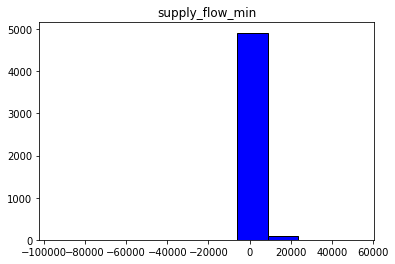

In [78]:
import matplotlib.pyplot as pyplot
fig = pyplot.hist(train_features_w_response[col_name], color = 'blue', edgecolor = 'black', bins=10, label=col_name)
pyplot.title(col_name)
pyplot.savefig("pyplot.png")

In [67]:
train_features_w_response[col_name].max()

53153.937999999995

In [68]:
train_features_w_response[col_name].min()

-94814.82